## PFI METHOD SHUFFLING PAST COVARIATES

In [ ]:
%tensorboard --logdir logs #Clik above this to open tensorboard!

# data creation:

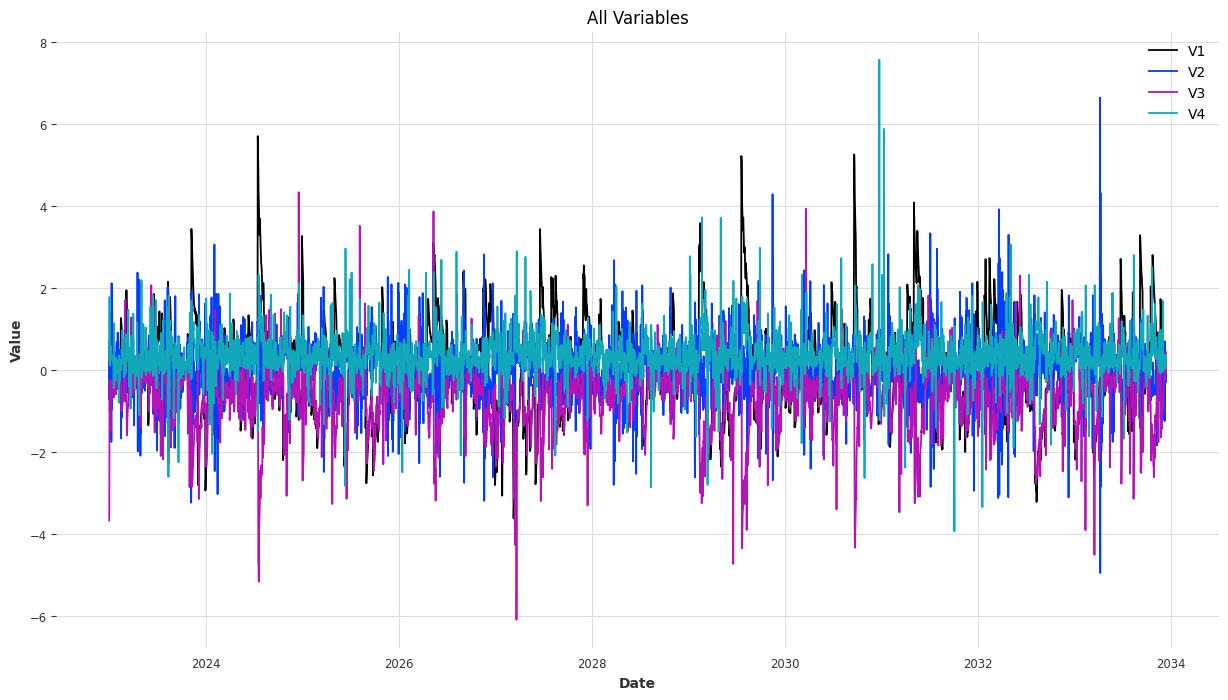

Data loaded and prepared for modeling.
Training set size: 3600
Test set size: 400


In [191]:
import numpy as np
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
default_float = np.float32
random_seed = 42

# Load the CSV file
df = pd.read_csv('data_0.csv')  # Replace with your actual file name

# Convert the time_index to datetime
df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')

# Set the timestamp as the index
df.set_index('timestamp', inplace=True)

# Drop the original time_index column if it's still present
df = df.drop('time_index', axis=1, errors='ignore')

# Convert to TimeSeries objects
target_variable = "V3"
covariates_names = ['V1', 'V2', 'V4']
target = TimeSeries.from_series(df[target_variable].astype(default_float))  # Using from_series for a single column
covariates = TimeSeries.from_dataframe(df[covariates_names].astype(default_float))

# Split into train and test sets
train_test_split = int(0.9 * len(target))
train_target, test_target = target[:train_test_split], target[train_test_split:]
train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

# # Plotting
# plt.figure(figsize=(15, 10))

# # Plot each input variable
# for i, col in enumerate(['V1', 'V2', 'V3']):
#     plt.subplot(2, 2, i+1)
#     plt.plot(df.index, df[col])
#     plt.title(f'Variable {col}')
#     plt.xlabel('Date')
#     plt.ylabel('Value')

# # Plot the target variable
# plt.subplot(2, 2, 4)
# plt.plot(df.index, df['V4'])
# plt.title('Target Variable V4')
# plt.xlabel('Date')
# plt.ylabel('Value')

# plt.tight_layout()
# plt.show()

# Plot all variables together
plt.figure(figsize=(15, 8))
for col in ['V1', 'V2', 'V3', 'V4']:
    plt.plot(df.index, df[col], label=col)
plt.title('All Variables')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("Data loaded and prepared for modeling.")
print(f"Training set size: {len(train_target)}")
print(f"Test set size: {len(test_target)}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Epoch 49: 100%|██████████| 112/112 [00:13<00:00,  8.49it/s, v_num=logs, train_loss=1.100]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 112/112 [00:13<00:00,  8.49it/s, v_num=logs, train_loss=1.100]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.96it/s]


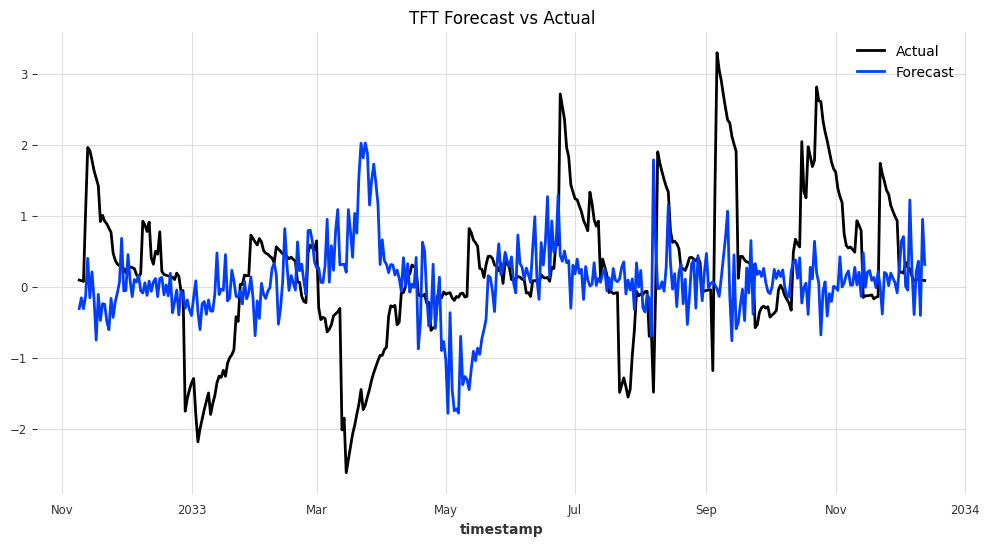

Real loss: 1.415205717086792


In [107]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
from copy import deepcopy
import datetime, os


# Train the model and get the real loss
model = TFTModel(
    model_name="FINAL1_tft_targetv4",
    input_chunk_length=30,
    output_chunk_length=14,
    hidden_size=64,
    lstm_layers=2,
    num_attention_heads=4,
    #output_chunk_shift = 15,
    batch_size=32,
    n_epochs=50,
    add_relative_index=True,
    log_tensorboard=True,
)



# Train the full model
model.fit(train_target, past_covariates=train_covariates, verbose=True)

# Get the real loss
deterministic_prediction = model.predict(n=len(test_target), series=train_target, past_covariates=covariates)
realloss = mse(test_target, deterministic_prediction)

# print(f"First loss: {firstloss}")
print(f"Real loss: {realloss}")
num_samples = 100
predictions = model.predict(n=len(test_target), series=train_target, past_covariates=covariates, num_samples=num_samples)
quantile_predictions = predictions.quantile_timeseries(0.5)
realloss = mse(test_target, quantile_predictions)
print(f"Quantile Real loss: {realloss}")

# Plot results
plt.figure(figsize=(12, 6))
test_target.plot(label="Actual")
quantile_predictions.plot(label="Forecast")
plt.title("TFT Forecast vs Actual")
plt.legend()
plt.show()



`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  0.33it/s]
Real loss: 1.307606483533259


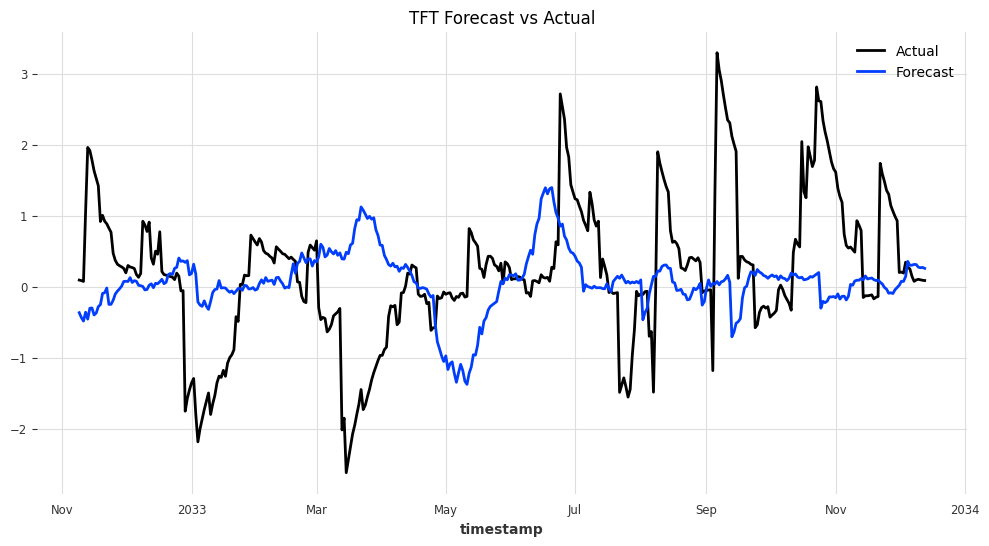

In [110]:
# Get the real loss
num_samples = 100
A_predictions = model.predict(n=len(test_target), series=train_target, past_covariates=covariates, num_samples=num_samples)
predictions = A_predictions.quantile_timeseries(0.5)
realloss = mse(test_target, predictions)
print(f"Real loss: {realloss}")
# Plot results
plt.figure(figsize=(12, 6))
test_target.plot(label="Actual")
predictions.plot(label="Forecast")
plt.title("TFT Forecast vs Actual")
plt.legend()
plt.show()

In [111]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
from copy import deepcopy
import datetime, os

# Function to shuffle a specific column in the covariates
def shuffle_covariate(covariates, column_name):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

print(f"Real loss: {realloss}")
# PFI
threshold = 1.0  # You can adjust this value


for column in covariates.columns:
    # Shuffle the current covariate
    shuffled_covariates = shuffle_covariate(covariates, column)

    num_samples=100

    # Make predictions using the shuffled covariate
    shuffled_predictions = model.predict(n=len(test_target), series=train_target, past_covariates=shuffled_covariates, num_samples=num_samples)
    predictions = shuffled_predictions.quantile_timeseries(0.5)
    # Calculate the loss with shuffled covariate
    shuffled_loss = mse(test_target, predictions)
    
    # Calculate the PFI ratio
    pfi_ratio = realloss / shuffled_loss 
    
    print(f"{column}: shuffled_loss = {shuffled_loss}, pfi_ratio = {pfi_ratio}")
    



`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.33it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Real loss: 1.3103587425798195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



V2: shuffled_loss = 1.5170914814149563, pfi_ratio = 0.8637308683308129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  0.31it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



V3: shuffled_loss = 1.1024856761214392, pfi_ratio = 1.188549448723616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]
V4: shuffled_loss = 1.2437103751334182, pfi_ratio = 1.0535883343734684


In [5]:
import json
import math

results = [
    {
        'target': 'var1',
        'realloss': 1.2012574991874527,
        'shuffleloss': {
            'var1': math.nan, #NOT TESTED
            'var2': 1.0986757181564843,  # Strong influence on var2
            'var3': 1.2545720584978246,  # Strong influence on var3
            'var4': 1.180358356554931   # No direct influence
        }
    },
    {
        'target': 'var2',
        'realloss': 0.6337809378064478,
        'shuffleloss': {
            'var1': 0.7067485929328001,  # Influenced by var1
            'var2': math.nan, #NOT TESTED
            'var3': 0.6072010930492837,
            'var4': 0.630015231922147   # Influence on var4
        }
    },
    {
        'target': 'var3',
        'realloss': 0.6699895107843895,
        'shuffleloss': {
            'var1': 0.8168473609735537,  # Influenced by var1
            'var2': 0.6026409617480087,
            'var3': math.nan, #NOT TESTED
            'var4': 0.6892307461700793   # Influence on var4
        }
    },
    {
        'target': 'var4',
        'realloss': 0.20563022563380356,
        'shuffleloss': {
            'var1': 0.318698161609292,
            'var2': 0.337949219107592,  # Influenced by var2
            'var3': 0.3454339468106876,  # Influenced by var3
            'var4': math.nan  #NOT TESTED
        }
    }
]

# Save this to a file
with open('./PFI_results/dataset_0_shuffeled_past_covariates.json', 'w') as f:
    json.dump(results, f, indent=2)

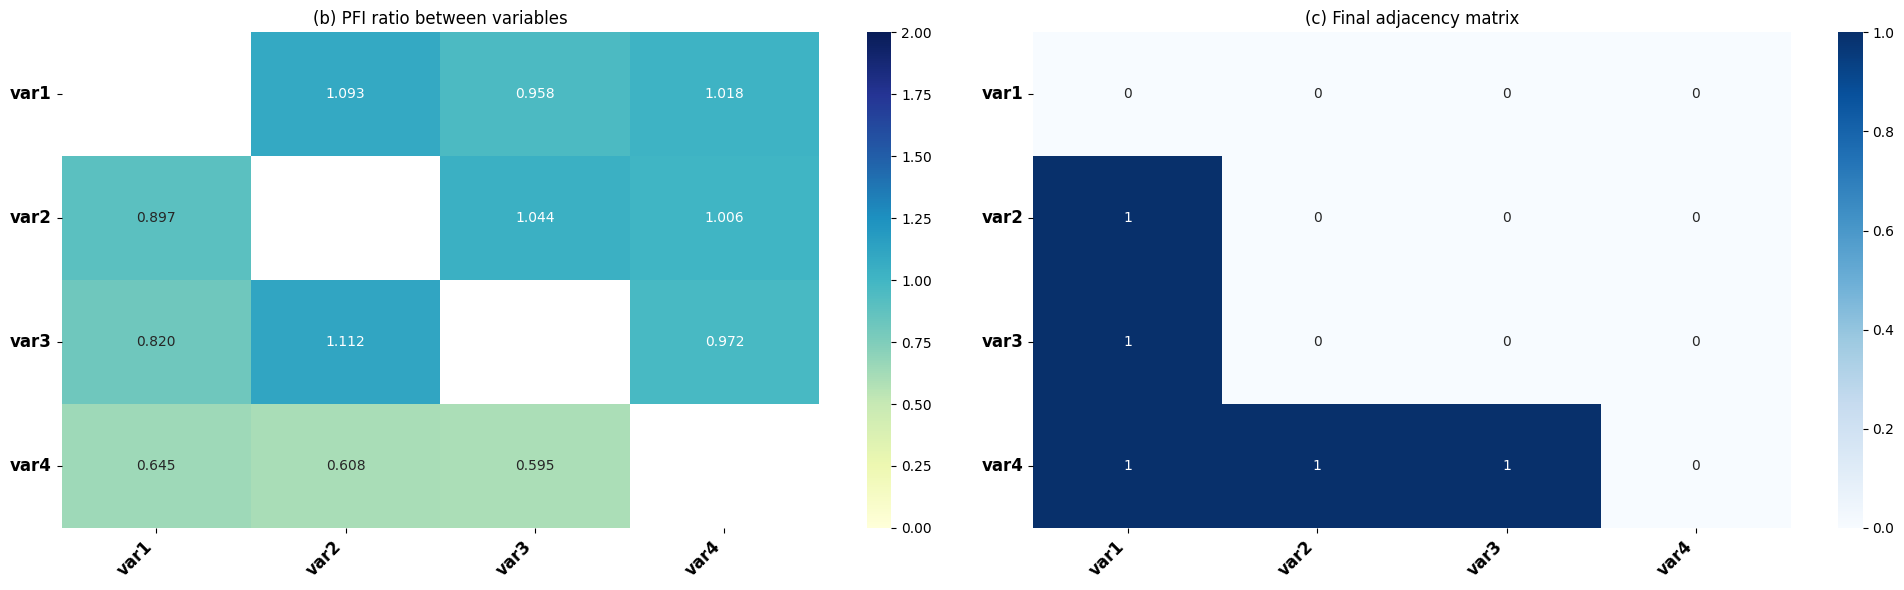

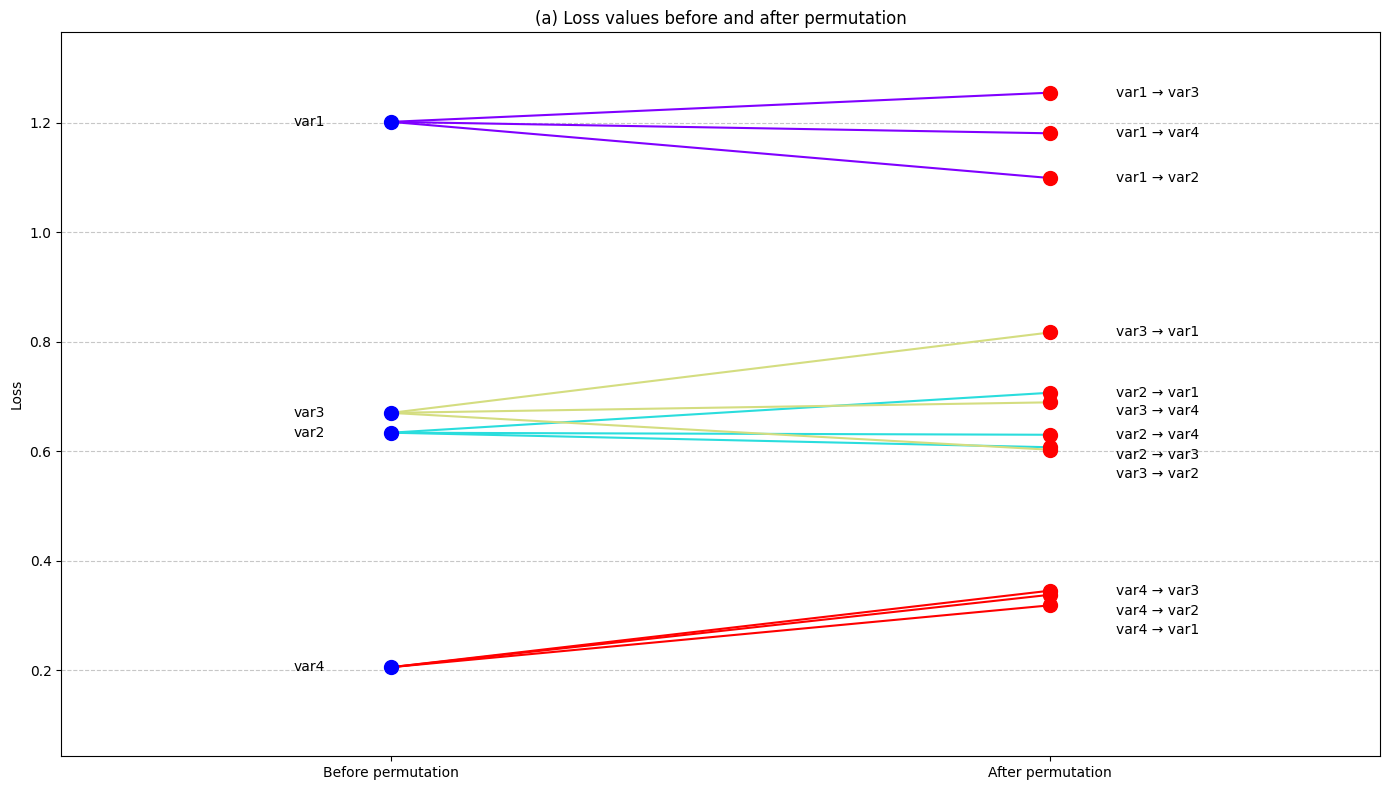

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

# Load results from the file
with open('./PFI_results/dataset_0_shuffeled_past_covariates.json', 'r') as f:
    results = json.load(f)

variables = [result['target'] for result in results]
n_vars = len(variables)
 # 3 plots of visualizations
#NEED TO MAKE FUNCTIONS OF THIS CODE LATER: 

# Prepare data for visualization
losses_before = np.array([result['realloss'] for result in results])
losses_after = np.array([[result['shuffleloss'][var] for var in variables] for result in results])
pfi_ratios = losses_before[:, np.newaxis] / losses_after

# Create visualizations
fig, ( ax2, ax3) = plt.subplots(1, 2, figsize=(20, 6))

# (b) The PFI ratio between every two variables
sns.heatmap(pfi_ratios, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax2, vmin=0, vmax=2)
ax2.set_xticklabels(variables, rotation=45, ha='right',fontsize=12, fontweight='bold')
ax2.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
ax2.set_title('(b) PFI ratio between variables')

# (c) The final adjacency matrix
threshold = 0.9  # Adjust as needed
adjacency_matrix = (pfi_ratios < threshold).astype(int)
sns.heatmap(adjacency_matrix, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_xticklabels(variables, rotation=45, ha='right',fontsize=12, fontweight='bold')
ax3.set_yticklabels(variables, rotation=0,fontsize=12, fontweight='bold')
ax3.set_title('(c) Final adjacency matrix')

plt.tight_layout()
plt.show()


colors = plt.cm.rainbow(np.linspace(0, 1, n_vars))

plt.figure(figsize=(14, 8))  # Increased figure width for better label placement

# Dictionary to store y-positions of labels
label_positions = {}

for i, result in enumerate(results):
    target = result['target']
    realloss = result['realloss']
    color = colors[i]
    
    # Plot a line for each variable being permuted, excluding NaN values
    for var, shuffleloss in result['shuffleloss'].items():
        if not math.isnan(shuffleloss):
            plt.plot([1, 2], [realloss, shuffleloss], '-', color=color,
                     label=f'{target} (permute {var})' if var == target else "")
            
            # Store the y-position for the label
            if shuffleloss in label_positions:
                label_positions[shuffleloss].append(f"{target} → {var}")
            else:
                label_positions[shuffleloss] = [f"{target} → {var}"]

    # Plot points
    plt.scatter([1], [realloss], color='blue', s=100, zorder=5)
    valid_shuffleloss = [loss for loss in result['shuffleloss'].values() if not math.isnan(loss)]
    plt.scatter([2] * len(valid_shuffleloss), valid_shuffleloss,
                color='red', s=100, zorder=5)

    # Add variable labels on the left side
    plt.text(0.9, realloss, target, ha='right', va='center')

# Sort the label positions
sorted_positions = sorted(label_positions.items(), reverse=True)

# Function to check if two labels overlap
def labels_overlap(y1, y2, height):
    return abs(y1 - y2) < height

# Add labels on the right side with adjusted positions
label_height = 0.03  # Increased label height for better separation
placed_labels = []

for y_pos, labels in sorted_positions:
    for label in labels:
        adjusted_y = y_pos
        while any(labels_overlap(adjusted_y, pl[0], label_height) for pl in placed_labels):
            adjusted_y -= label_height / 2
        placed_labels.append((adjusted_y, label))

# Sort placed labels by their adjusted y-position
placed_labels.sort(reverse=True)

# Plot the labels
for adjusted_y, label in placed_labels:
    plt.text(2.1, adjusted_y, label, ha='left', va='center')

# Customize the plot
plt.xlim(0.5, 2.5)
max_loss = max(max(max(loss for loss in result['shuffleloss'].values() if not math.isnan(loss)), result['realloss']) for result in results)
y_margin = 0.1 * (max_loss - plt.ylim()[0])  # 10% margin
plt.ylim(plt.ylim()[0] - y_margin, max_loss + y_margin)
plt.xticks([1, 2], ['Before permutation', 'After permutation'])
plt.ylabel('Loss')
plt.title('(a) Loss values before and after permutation')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:

# # Save the results
# target_results = {
#     'target': target_variable,
#     'realloss': realloss,
#     'shuffleloss': {var: shuffleloss for var, pfi_ratio in zip(variables, shuffleloss)}
# }
# results.append(target_results)